In [12]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile
import os
from patchify import patchify  #Only to handle large images
import random
from scipy import ndimage
from pathlib import Path
import zarr
from pathlib import Path
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from natsort import natsorted
import matplotlib.pyplot as plt
import torch
import cv2
import os
from skimage.measure import label, regionprops

%matplotlib inline

BASE_PATH = Path("/scratch/ventricle_dataset/train")

def compute_iou(box1, box2, thesh_area=0.8):
    # If the intersection area is higher than thresh area
    # I return a high IoU even if the computed in low
    # only for box2 since box1 is assumed to have a bigger area
    x1, y1, x2, y2 = box1
    x1_p, y1_p, x2_p, y2_p = box2

    # Calculate intersection
    xi1 = max(x1, x1_p)
    yi1 = max(y1, y1_p)
    xi2 = min(x2, x2_p)
    yi2 = min(y2, y2_p)
    inter_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)
    
    # Calculate union
    box1_area = (x2 - x1) * (y2 - y1)
    box2_area = (x2_p - x1_p) * (y2_p - y1_p)
    union_area = box1_area + box2_area - inter_area

    area_b2_from_inter = inter_area / box2_area 

    thesh_area 
    # Compute IoU
    iou = inter_area / union_area

    if iou > 0 and area_b2_from_inter <= 1.0 and area_b2_from_inter > thesh_area:
        return 1.0
        
    return iou

def filter_bboxes_by_area(bboxes, iou_threshold=0.5, thesh_area=0.2):
    # Calculate the area of each bounding box
    areas = [(box[2] - box[0]) * (box[3] - box[1]) for box in bboxes]
    # Sort bounding boxes by area in descending order
    sorted_indices = np.argsort(-np.array(areas))
    bboxes = [bboxes[i] for i in sorted_indices if areas[i] > 140]
    # print("Sorted boxes: ", bboxes)
    selected_bboxes = []

    while bboxes:
        # Choose the bounding box with the largest area
        chosen_box = bboxes.pop(0)
        selected_bboxes.append(chosen_box)

        # Remove boxes that overlap with the chosen box
        bboxes = [box for box in bboxes if compute_iou(
                chosen_box,
                box,
                thesh_area=thesh_area
            ) < iou_threshold
        ]

    return selected_bboxes

def get_bounding_box(ground_truth_map, iou_threshold=0.5):
    ground_truth_map = np.squeeze(ground_truth_map)
    H, W = ground_truth_map.shape
    labeled_mask = label(ground_truth_map)
    regions = regionprops(labeled_mask)
    bboxes = []
    
    for r in regions:
        min_row, min_col, max_row, max_col = r.bbox
        min_col = max(0, min_col - np.random.randint(0, 20))
        max_col = min(W, max_col + np.random.randint(0, 20))
        min_row = max(0, min_row - np.random.randint(0, 20))
        max_row = min(H, max_row + np.random.randint(0, 20))
        
        bboxes.append([
            float(min_col),
            float(min_row),
            float(max_col),
            float(max_row),
        ])
        bboxes = filter_bboxes_by_area(bboxes, iou_threshold=iou_threshold)
        bboxes = [list(b) for b in bboxes]
        # print("Filtered bboxs: ", bboxes)
    
    return bboxes

class NumpyDataset(Dataset):
    def __init__(self, image_path, labels_path, points, processor, transform=None):
        """
        Args:
            images (list or numpy array): List of images as NumPy arrays.
            labels (list or numpy array): List of labels as NumPy arrays or other formats.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.labels_paths = natsorted(
            [str(p.name) for p in list(Path(image_path).glob("*.npy"))]
        )
        self.image_base_path = Path(image_path)
        self.labels_base_path = Path(labels_path)
        self.points = points.copy()
        self.processor = processor
        self.transform = transform

    def __len__(self):
        return len(self.labels_paths)

    def __getitem__(self, idx):
        path = self.labels_paths[idx]
        slice_idx = int(path.split('_')[-1].replace('.npy', ''))
        slice_points = self.points[self.points[:, 0] == slice_idx]
        if not slice_points.shape[0]:
            raise ValueError(f"Problem getting points from image {path} {slice_idx}")

        # slice_points = slice_points[:, 1:]
        image = np.load(self.image_base_path.joinpath(self.labels_paths[idx])).astype(np.float32)
        label = np.load(self.labels_base_path.joinpath(self.labels_paths[idx])).astype(np.uint8)
        bbox_prompt = get_bounding_box(label)
        
        if self.transform:
            bbox_prompt = [ b + ['ventricle'] for b in bbox_prompt]
            augmented_data = self.transform(
                image=image,
                mask=label,
                bboxes=bbox_prompt,
            )
            image = augmented_data['image'].detach().cpu().numpy()
            label = augmented_data['mask'].detach().cpu().numpy()
            bbox_prompt = augmented_data['bboxes']
            bbox_prompt = [list(b[:-1]) for b in bbox_prompt]

        else:
            image = np.expand_dims(image, axis=0)
        # if not isinstance(image, torch.Tensor):
        #     image = torch.tensor(image[np.newaxis, ...], dtype=torch.float32)

        # if not isinstance(label, torch.Tensor):
        #     label = torch.tensor(label, dtype=torch.long)

        image = image.transpose( (1,2,0) ) / 255
        image = np.concatenate([image]*3, axis=-1)
        # print(bbox_prompt)

        # print(image.shape, label.shape,image.dtype, label.dtype, len(slice_points), slice_points)
        # slice_points.tolist()
        inputs = self.processor(image, input_boxes=[bbox_prompt], return_tensors="pt", input_data_format="channels_last", do_rescale=False)#, input_data_format=ChannelDimension.FIRST)
    
        # remove batch dimension which the processor adds by default
        inputs = {k:v.squeeze(0) for k,v in inputs.items()}
    
        # add ground truth segmentation
        inputs["ground_truth_mask"] = label
        
        return inputs

In [13]:
# bbox_test = [[315.0, 546.0, 439.0, 639.0], [497.0, 457.0, 552.0, 515.0], [607.0, 578.0, 667.0, 616.0], [498.0, 532.0, 535.0, 566.0], [656.0, 577.0, 659.0, 607.0]]
# print("start: ", len(bbox_test))
# f_bbox_test = filter_bboxes_by_area(bbox_test, iou_threshold=0.2)

# print("End: ", len(f_bbox_test), f_bbox_test)
# compute_iou([607.0, 578.0, 667.0, 616.0], [656.0, 577.0, 659.0, 607.0])

In [14]:
from albumentations.pytorch import ToTensorV2
import albumentations as A

augmentations = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.5),
    # A.RandomBrightnessContrast(p=0.5),
    A.GaussianBlur(p=0.5),
    ToTensorV2()
], bbox_params=A.BboxParams(format='pascal_voc'))#, label_fields=['ventricle']))
                          
#keypoint_params=A.KeypointParams(format='yx', remove_invisible=True))

In [15]:
from transformers import SamProcessor
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

In [16]:
points = np.load(BASE_PATH.joinpath('points/smartspim_693196_vs_pts.npy'))
ventricle_dataset = NumpyDataset(
    image_path=BASE_PATH.joinpath('images'),
    labels_path=BASE_PATH.joinpath('labels'),
    points=points,
    processor=processor,
    transform=augmentations
)

In [6]:
def custom_collate(batch):
    # print(batch[0].keys())
    pixel_values = []
    original_sizes = []
    reshaped_input_sizes = []
    input_boxes = []
    ground_truth_mask = []

    for b in batch:
        pixel_values.append(b['pixel_values'])
        original_sizes.append(b['original_sizes'])
        reshaped_input_sizes.append(b['reshaped_input_sizes'])
        input_boxes.append(b['input_boxes'])
        ground_truth_mask.append(b['ground_truth_mask'])

    return pixel_values, original_sizes, reshaped_input_sizes, input_boxes, ground_truth_mask

dataloader = DataLoader(ventricle_dataset, batch_size=16, shuffle=False, collate_fn=custom_collate)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..1.0365143].


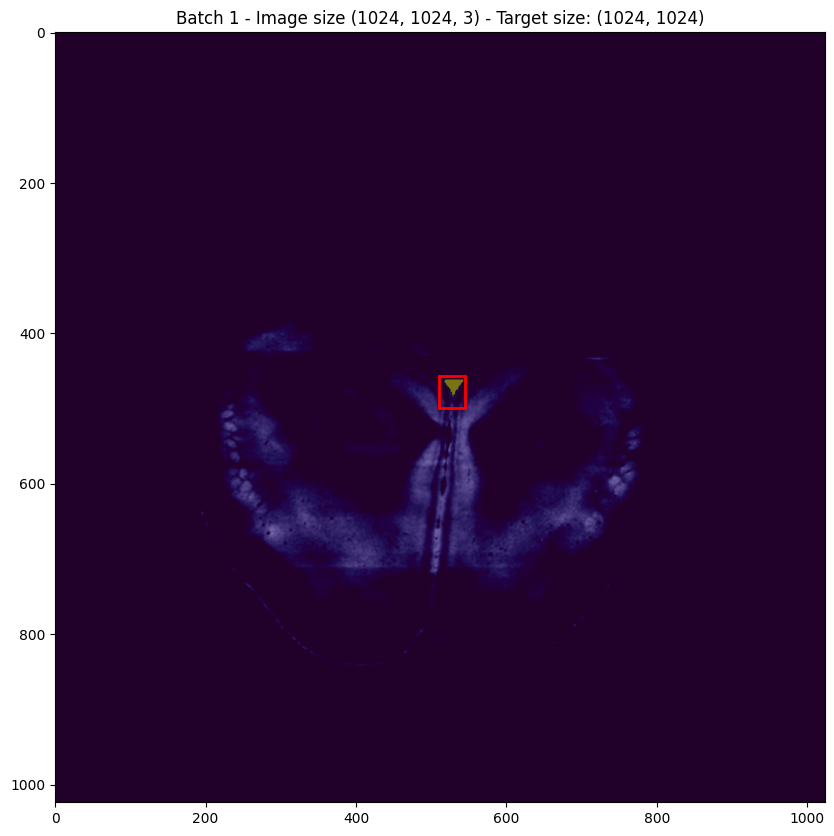

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..1.6988237].


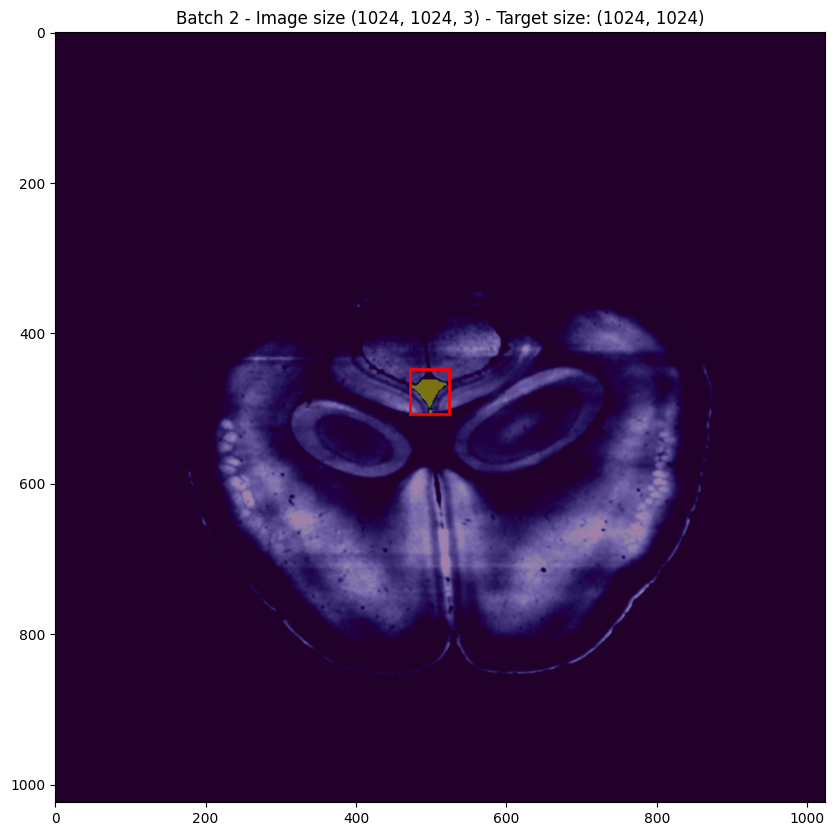

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


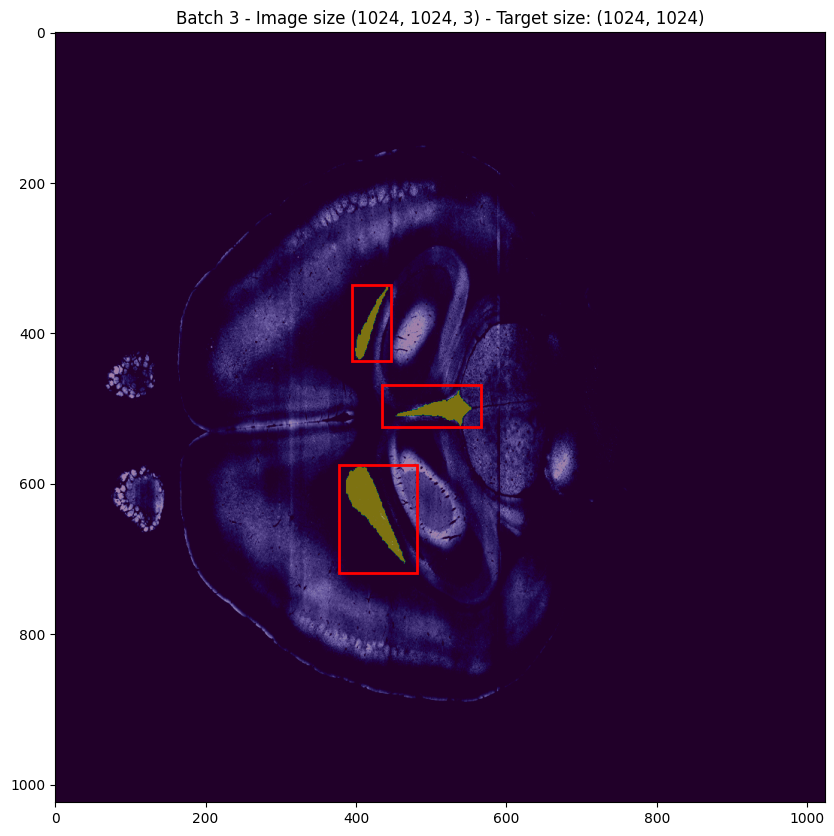

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0151556..1.4722441].


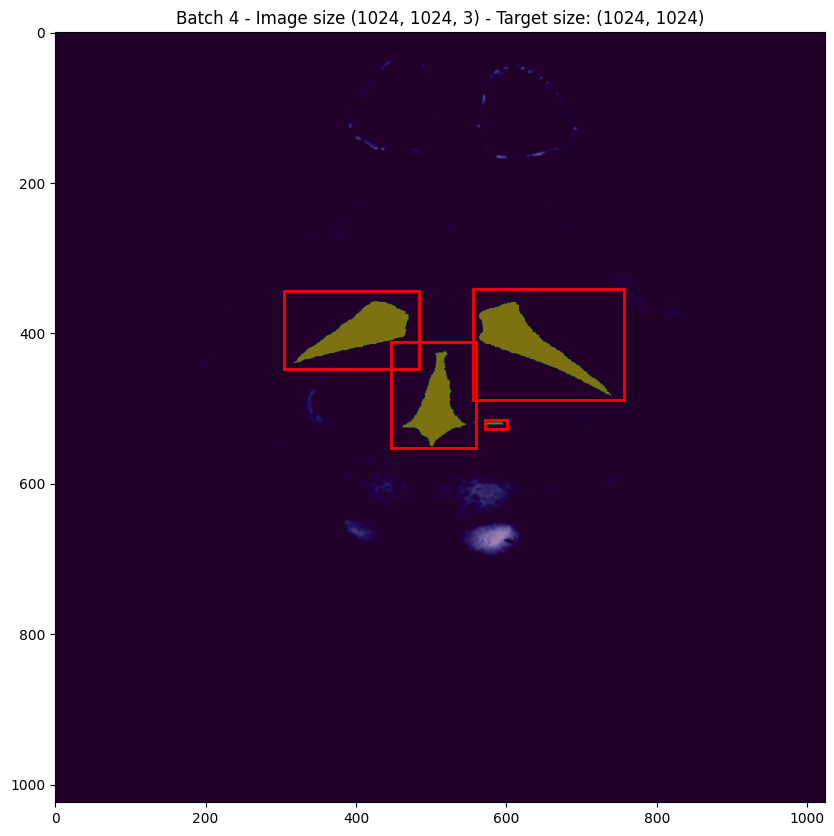

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0151556..2.0822659].


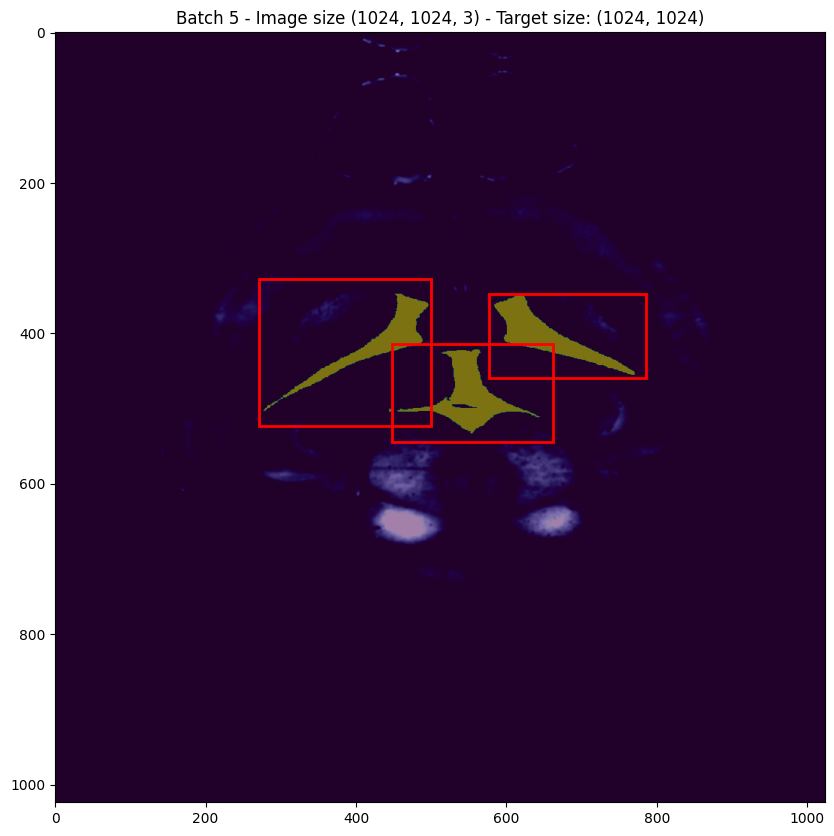

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.980906..1.454815].


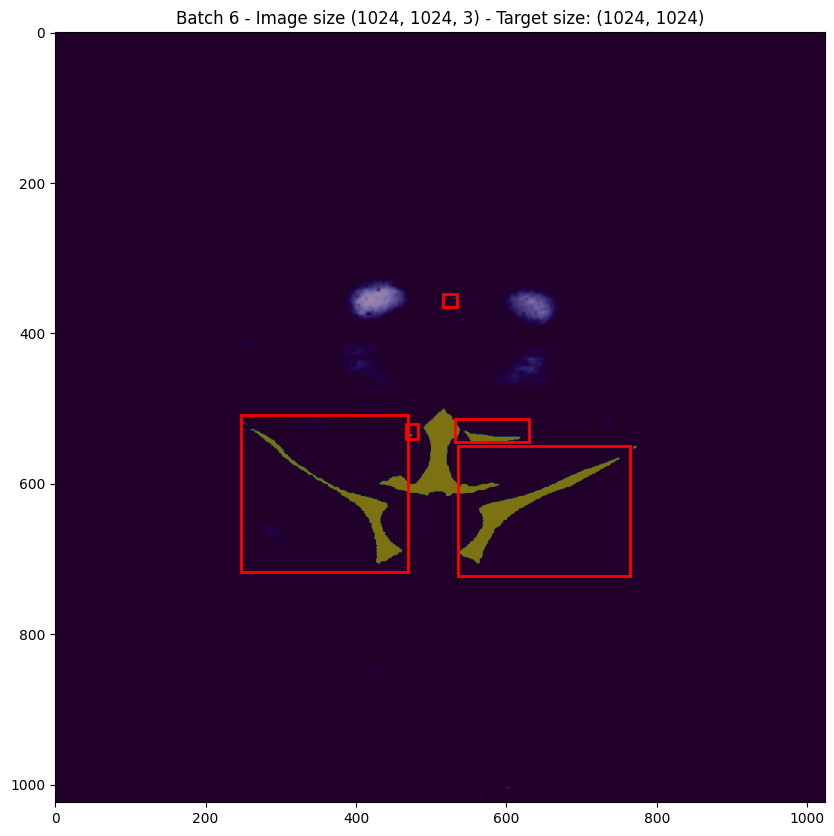

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9637812..2.2216995].


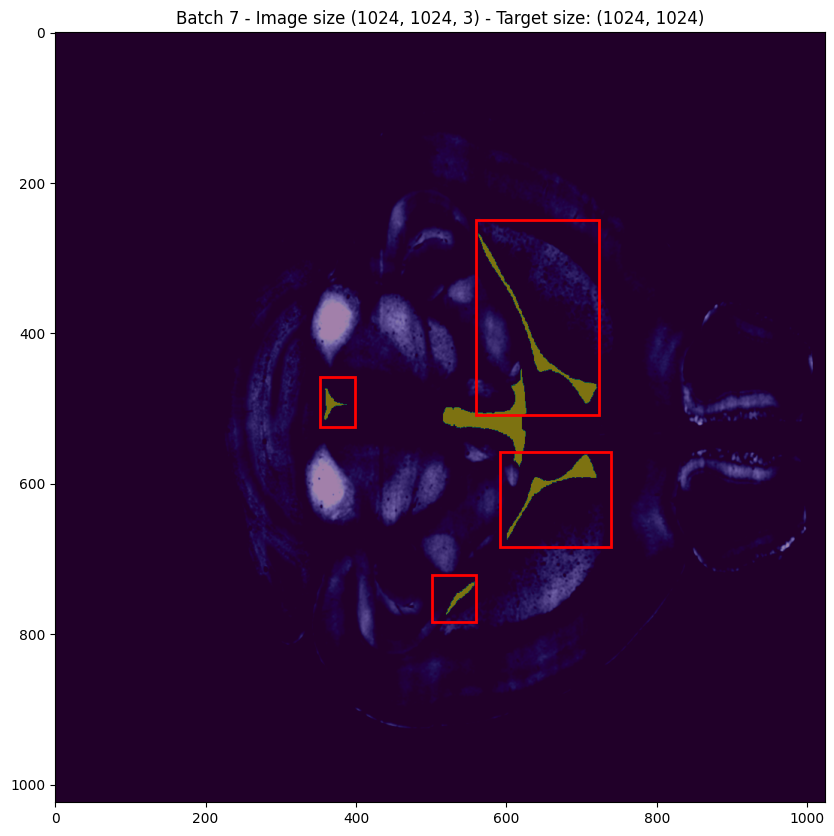

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


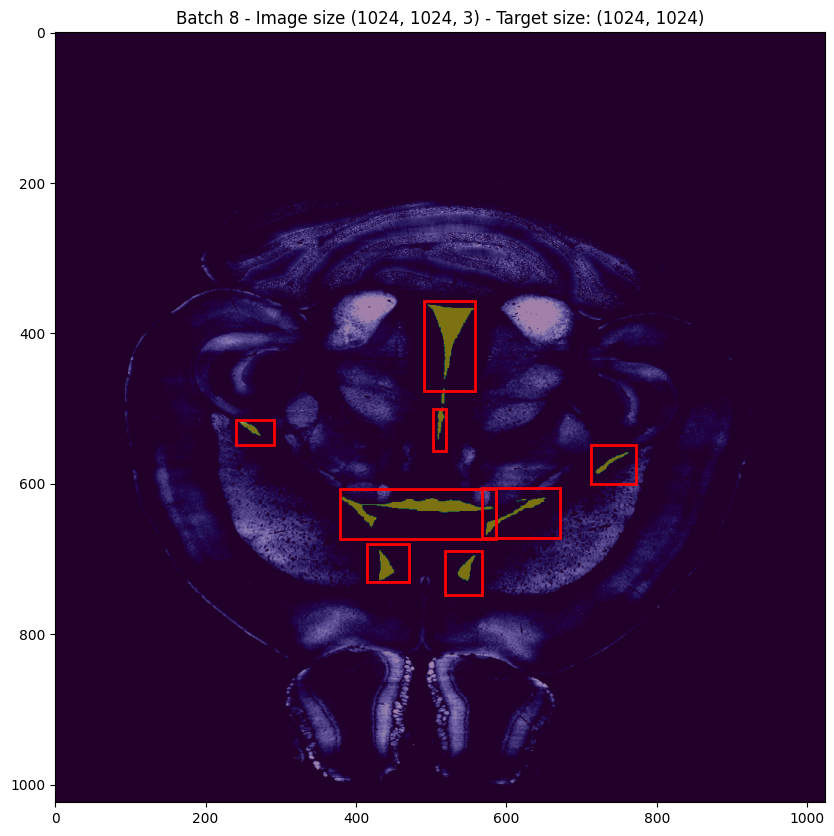

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9980307..1.6291069].


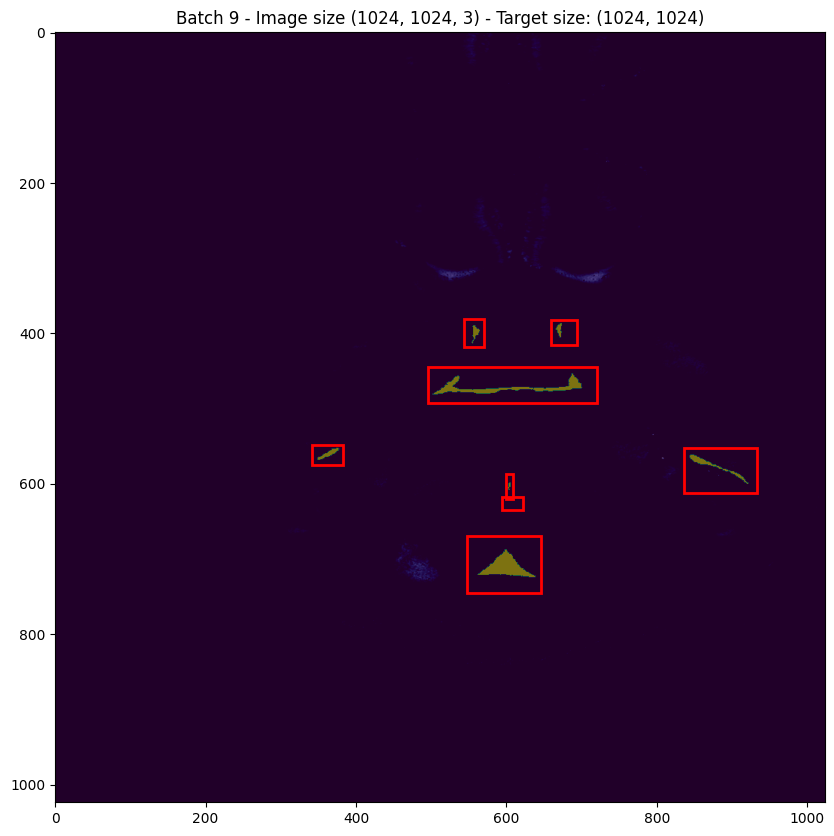

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7411594..0.23477131].


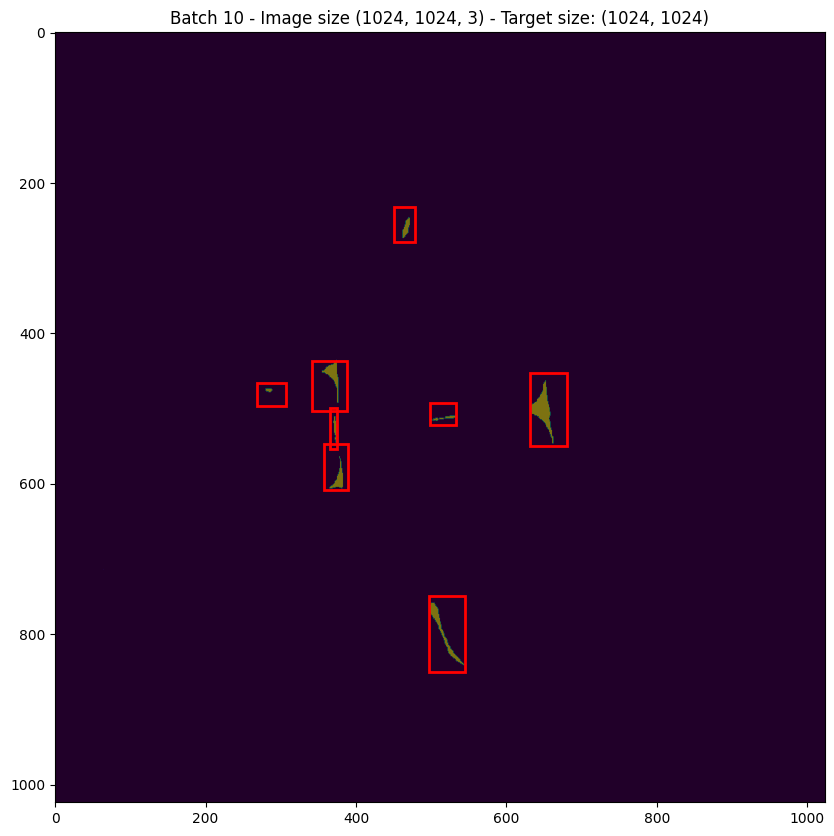

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9124069..0.14762534].


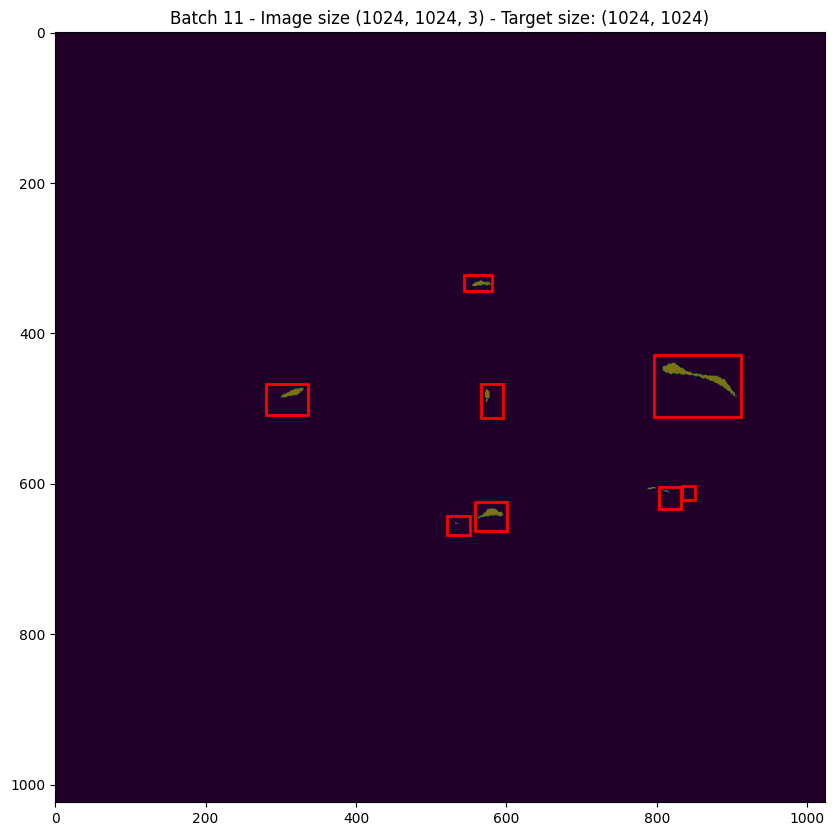

In [17]:
limit = 10
for batch_idx, (pixel_values, original_sizes, reshaped_input_sizes, input_boxes, ground_truth_mask) in enumerate(dataloader):
    idx = -1
    
    slice_img = pixel_values[idx].detach().cpu().numpy().transpose((1,2,0))
    gt_mask = ground_truth_mask[idx]
    curr_box = input_boxes[idx]
    # slc_pts = input_points[idx].detach().cpu().numpy().squeeze()
    # slc_pts = np.expand_dims(slc_pts, axis=0)
    # if len(slc_pts) == 1:
    #     slc_pts = np.expand_dims(slc_pts, axis=0)
    # print(slc_pts.shape)
    # print(slc_pts[:, 1], slc_pts[:, 0])
    # pt_lbl = pts_lbls[idx]

    # print(data[idx].min(), data[idx].max(), data[idx].shape)
    
    plt.figure(figsize=(10,10))
    plt.imshow(slice_img, cmap="gray")
    plt.imshow(gt_mask, alpha=0.5)

    for box in curr_box:
        x_min, y_min, x_max, y_max = box
        width = x_max - x_min
        height = y_max - y_min
        
        # Create a Rectangle and add it to the plot
        rect = plt.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='r', facecolor='none')
        plt.gca().add_patch(rect)

    # plt.scatter(slc_pts[:, 1], slc_pts[:, 0], c='red', s=1)
    plt.title(f"Batch {batch_idx + 1} - Image size {slice_img.shape} - Target size: {gt_mask.shape}")# - pts: {len(slc_pts)}")
    plt.show()

    if batch_idx == limit:
        break

In [8]:
from transformers import SamModel
model = SamModel.from_pretrained("facebook/sam-vit-base")

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
    if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
        param.requires_grad_(False)

In [9]:
from torch.optim import Adam, AdamW
import monai

lr = 1e-2
wd = 4e-3

# Only optimizing the decoder
optimizer = Adam(model.parameters(), lr=lr, weight_decay=wd) # mask_decoder.
#Try DiceFocalLoss, FocalLoss, DiceCELoss
seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')
# seg_loss = monai.losses.DiceFocalLoss(sigmoid=True, squared_pred=True, reduction='mean')

In [18]:
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize

#Training loop
num_epochs = 50

highest_iou = 0.79

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()
for epoch in range(num_epochs):
    epoch_losses = []
    iou_scores = []
    pbar = tqdm(dataloader)
    for batch in pbar:
        # Getting data from batch
        pixel_values, original_sizes, reshaped_input_sizes, input_boxes, ground_truth_masks = batch

        # Stacking since we needed to have a collate function
        pixel_values = torch.stack(pixel_values, dim=0).to(device)
        ground_truth_masks = torch.stack(
            [torch.tensor(np_arr, dtype=torch.float32)
             for np_arr in ground_truth_masks],
            dim=0
        )
        original_sizes = torch.stack(original_sizes, dim=0)
        reshaped_input_sizes = torch.stack(reshaped_input_sizes, dim=0)

        pred_masks = []
        batch_iou = []
        # Executing a loop since we could have a batch
        # with one box and the next with 3 and we can't cat that
        for img_idx in range(len(input_boxes)):
            pix_val = pixel_values[img_idx][None, ...]
            inp_box = input_boxes[img_idx][None, ...]
            # print(inp_box.shape)
            
            sam_pred = model(
                pixel_values=pix_val,
                input_boxes=inp_box.to(device),
                multimask_output=False
            )
            
            scores = sam_pred.iou_scores

            pred_mask = sam_pred.pred_masks.cpu()
            orig_size = original_sizes[img_idx][None, ...].cpu()
            reshaped_size = reshaped_input_sizes[img_idx][None, ...].cpu()

            up_pred_mask = processor.image_processor.post_process_masks(
                pred_mask,
                orig_size,
                reshaped_size
            )

            # SAM generates a single mask per box, so I'm concatenating them
            if inp_box.shape[1] != 1:
                # up_pred_mask = up_pred_mask[0].float().mean(0)
                up_pred_mask, _ = torch.max(up_pred_mask[0].float(), dim=0)
                scores = scores.detach().cpu().numpy().squeeze().mean()

            else:
                up_pred_mask = up_pred_mask[0].float()
                scores = scores.detach().cpu().numpy().squeeze()
                
            pred_masks.append(
                up_pred_mask.squeeze()
            )
            batch_iou.append(
                scores
            )
        
        # GT
        ground_truth_masks = ground_truth_masks.float().to(device).float()

        up_pred_masks = torch.stack(pred_masks, dim=0).to(device).float()

        if not up_pred_masks.requires_grad:
            up_pred_masks = up_pred_masks.requires_grad_()

        if not ground_truth_masks.requires_grad:
            ground_truth_masks = ground_truth_masks.requires_grad_()

        # Computing loss
        loss = seg_loss(up_pred_masks, ground_truth_masks)
        
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        
        # optimize
        optimizer.step()
        epoch_losses.append(loss.item())
        
        batch_iou = np.stack(batch_iou)
        miou = batch_iou.mean()
        iou_scores.append(miou)
        pbar.set_postfix({'Batch IOU': miou, 'Loss': loss.item()})

    mean_iou_epoch = np.array(iou_scores).mean()

    if highest_iou < mean_iou_epoch:
        torch.save(model.state_dict(), f"sam_ventricle_{epoch}_{mean_iou_epoch}.pt")
        highest_iou = mean_iou_epoch.copy()

    print(f'EPOCH: {epoch} - Mean loss: {mean(epoch_losses)} - Mean IoU {mean_iou_epoch}')


100%|██████████| 25/25 [03:12<00:00,  7.70s/it, Batch IOU=0.681, Loss=2.23]


EPOCH: 0 - Mean loss: 41.31670390129089 - Mean IoU 0.7949175834655762


100%|██████████| 25/25 [03:13<00:00,  7.74s/it, Batch IOU=0.565, Loss=2.33]


EPOCH: 1 - Mean loss: 41.35947164535523 - Mean IoU 0.7905670404434204


100%|██████████| 25/25 [03:13<00:00,  7.74s/it, Batch IOU=0.754, Loss=2.32]


EPOCH: 2 - Mean loss: 41.18644561767578 - Mean IoU 0.7978167533874512


100%|██████████| 25/25 [03:13<00:00,  7.75s/it, Batch IOU=0.689, Loss=2.23]


EPOCH: 3 - Mean loss: 40.98669123649597 - Mean IoU 0.7977386713027954


100%|██████████| 25/25 [03:13<00:00,  7.75s/it, Batch IOU=0.681, Loss=2.31]


EPOCH: 4 - Mean loss: 41.315357632637024 - Mean IoU 0.7953570485115051


100%|██████████| 25/25 [03:12<00:00,  7.72s/it, Batch IOU=0.666, Loss=2.31]


EPOCH: 5 - Mean loss: 41.103061246871945 - Mean IoU 0.7937994599342346


100%|██████████| 25/25 [03:12<00:00,  7.69s/it, Batch IOU=0.717, Loss=2.15]


EPOCH: 6 - Mean loss: 41.22133770942688 - Mean IoU 0.7978414297103882


100%|██████████| 25/25 [03:12<00:00,  7.68s/it, Batch IOU=0.599, Loss=2.31]


EPOCH: 7 - Mean loss: 41.37375128746033 - Mean IoU 0.7915725111961365


100%|██████████| 25/25 [03:14<00:00,  7.77s/it, Batch IOU=0.688, Loss=2.41]


EPOCH: 8 - Mean loss: 40.950044298171996 - Mean IoU 0.7957646250724792


100%|██████████| 25/25 [03:13<00:00,  7.76s/it, Batch IOU=0.697, Loss=2.1] 


EPOCH: 9 - Mean loss: 41.640623264312744 - Mean IoU 0.7965756058692932


100%|██████████| 25/25 [03:14<00:00,  7.77s/it, Batch IOU=0.724, Loss=2.37]


EPOCH: 10 - Mean loss: 41.10617105484009 - Mean IoU 0.7940242886543274


  0%|          | 0/25 [00:04<?, ?it/s]

KeyboardInterrupt



In [ ]:
torch.cuda.empty_cache()